# Topological optimization of 2 clusters

In this notebook, we show how a topological loss can be use to optimize a data set for two clusters.

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import numpy as np

# Random sampling
import random

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load and view data

We generate the data as follows.

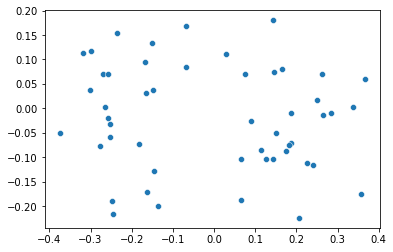

In [2]:
# Data parameters
points_per_cluster = 25
mu1 = np.array([-0.2, 0])
mu2 = np.array([0.2, 0])
sigma = 0.1

# Generate the data and labels
np.random.seed(420)
data = np.concatenate([mu1 + np.random.normal(size=(points_per_cluster, 2), scale=sigma),
                       mu2 + np.random.normal(size=(points_per_cluster, 2), scale=sigma)])

# Plot the data
fig, ax = plt.subplots()
sns.scatterplot(x=data[:,0], y=data[:,1])
plt.show()

## Apply topological optimization to the embedding

We now show how we can use topological optimization to encourage the model underlying the data to become connected. As a topological loss, we will use the persistence of the second most prominent gap.

In [3]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=0) # alpha complex layer
Component2Persistence = DiagramLoss(dim=0, i=2, j=2, g=g) # compute persistence of second most prominent gap

# Construct topological loss function
def top_loss(output):
    dgminfo = TopLayer(output)            
    loss = - Component2Persistence(dgminfo)
    
    return loss

We can now conduct the topological optimization as follows.

[epoch 1] [topological loss: -0.131397]
[epoch 10] [topological loss: -0.282094]
[epoch 20] [topological loss: -0.427987]
[epoch 30] [topological loss: -0.579585]
[epoch 40] [topological loss: -0.736238]
[epoch 50] [topological loss: -0.896679]
[epoch 60] [topological loss: -1.062835]
[epoch 70] [topological loss: -1.235956]
[epoch 80] [topological loss: -1.402753]
[epoch 90] [topological loss: -1.571399]
[epoch 100] [topological loss: -1.741448]


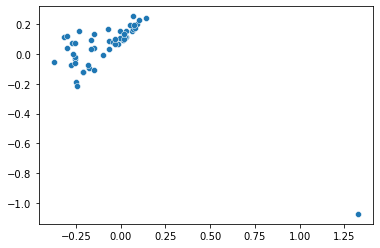

In [4]:
# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-2

# Conduct topological optimization
Y = torch.autograd.Variable(torch.tensor(data).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y], lr=learning_rate)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = top_loss(Y)
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % (int(num_epochs / 10)) == 0:
        print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
        
Y = Y.detach().numpy().copy()

# View topologically optimized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y[:,0], y=Y[:,1])
plt.show()

We see that the topological optimization served its purpose, i.e., it results in a point cloud consisting of two clusters. However, one of these clusters consists of merely one point. To accomodate for this, we can compute the topological loss from a random sample of our data as to represent larger clusters.

[epoch 1] [topological loss: -0.308334]
[epoch 10] [topological loss: -0.125648]
[epoch 20] [topological loss: -0.298769]
[epoch 30] [topological loss: -0.441468]
[epoch 40] [topological loss: -0.331700]
[epoch 50] [topological loss: -0.495583]
[epoch 60] [topological loss: -0.605348]
[epoch 70] [topological loss: -0.605039]
[epoch 80] [topological loss: -0.156322]
[epoch 90] [topological loss: -0.719416]
[epoch 100] [topological loss: -0.644189]


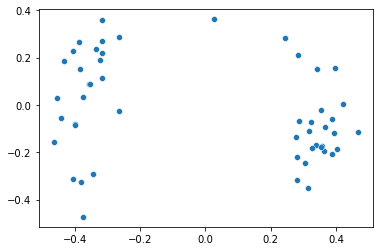

In [5]:
# Learning hyperparameters
top_frac = 0.10
num_epochs = 100
learning_rate = 1e-2

# Conduct topologically optimization
Y = torch.autograd.Variable(torch.tensor(data).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y], lr=learning_rate)

random.seed(42)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    I = random.sample(range(Y.shape[0]), int(Y.shape[0] * top_frac))
    loss = top_loss(Y[I,:])
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % (int(num_epochs / 10)) == 0:
        print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
        
Y = Y.detach().numpy().copy()

# View topologically optimized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y[:,0], y=Y[:,1])
plt.show()